<a href="https://colab.research.google.com/github/luisangel181/tesis_ingcivil/blob/main/Densidad_de_Bloques_de_Concreto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tesis: “RESISTENCIA A LA COMPRESIÓN DE ADOQUINES PARA PAVIMENTOS PEATONALES CON ESCORIA DE SOLDADURA, CAJAMARCA 2024”

Analisis estadistico ANOVA de los resultados de densidad de bloques de concreto

Elaborado por: luis Angel Vásquez Chávez

In [1]:
# librerias a importar
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import levene
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar archivo de resultados de resistencia a la compresion - cargar hoja "compresion"
df_densidad = pd.read_excel("/content/drive/MyDrive/RESULTADOS_TESIS CIVIL/Resultados_densidad.xlsx", sheet_name='Densidad')

# Visualizar datos
df_densidad.head()

,Dosificación,Bloque 1,Bloque 2,Bloque 3
0,Patrón,2265.851637,2268.112976,2268.432943
1,5% PE y 0.5% PET,2114.848236,2128.105906,2155.739400
2,10% PE y 0.5% PET,2038.662908,2056.175218,2064.496685
3,15% PE y 0.5% PET,1975.778547,1987.231455,1975.137559


Pruebas de Normalidad

Se Aplica prueba de Shapiro-Wilk para evaluar si los datos siguen uan distribucion de probabilidad normal. Se emplea en muestras pequeñas (<50 datos)

H0: Los datos siguen una distribución normal.

H1: Los datos no siguen una distribución normal.

Si p > 0.05, se acepta H₀ → Los datos son normales (Aplicar ANOVA clásico).

Si p < 0.05, se rechaza H₀ → Los datos no son normales (Aplicar ANOVA no paramétrico).

In [4]:
# Calcular media y desviación estándar para cada dosificación
df_densidad["Media (%)"] = df_densidad.iloc[:, 1:4].mean(axis=1)
df_densidad["Desviación estándar (%)"] = df_densidad.iloc[:, 1:4].std(axis=1)

# Función para aplicar Shapiro-Wilk y formatear los resultados en tabla
def aplicar_shapiro(data):
    resultados = []
    for i, dosificacion in enumerate(data["Dosificación"]):
        valores = data.iloc[i, 1:4].values
        stat, p = shapiro(valores)
        decision = "Acepta H₀ (Distribución normal)" if p > 0.05 else "Rechaza H₀ (No normal)"
        resultados.append([dosificacion, round(stat, 4), round(p, 4), decision])

    # Imprimir tabla
    print("\nPrueba de Shapiro-Wilk para Densidad (%)")
    print("=" * 60)
    print("{:<25} {:<12} {:<12} {:<25}".format("Dosificación", "Estadístico", "Valor p", "Resultado"))
    print("-" * 60)
    for row in resultados:
        print("{:<25} {:<12} {:<12} {:<25}".format(*row))

# Aplicar la prueba de Shapiro-Wilk
aplicar_shapiro(df_densidad)

# Aplicar prueba de Levene para homogeneidad de varianzas
valores_densidad = [df_densidad.iloc[i, 1:4].values for i in range(len(df_densidad))]
levene_stat, levene_p = levene(*valores_densidad, center='mean') #mean, median, trimmed , default es "median", Se ajusta distribucion normal == mean

# Mostrar resultados de Levene
print("\nPrueba de Levene para Homogeneidad de Varianzas")
print("=" * 60)
print("Estadístico: {:.4f}  |  Valor p: {:.4f}".format(levene_stat, levene_p))
decision_levene = "Acepta H₀ (Varianzas homogéneas)" if levene_p > 0.05 else "Rechaza H₀ (Varianzas no homogéneas)"
print("Resultado: {}\n".format(decision_levene))

df_densidad[["Dosificación", "Media (%)", "Desviación estándar (%)"]]


Prueba de Shapiro-Wilk para Densidad (%)
Dosificación              Estadístico  Valor p      Resultado                
------------------------------------------------------------
Patrón                    0.8414       0.2176       Acepta H₀ (Distribución normal)
5% PE y 0.5% PET          0.9604       0.6175       Acepta H₀ (Distribución normal)
10% PE y 0.5% PET         0.9595       0.6131       Acepta H₀ (Distribución normal)
15% PE y 0.5% PET         0.7896       0.09         Acepta H₀ (Distribución normal)

Prueba de Levene para Homogeneidad de Varianzas
Estadístico: 3.4584  |  Valor p: 0.0713
Resultado: Acepta H₀ (Varianzas homogéneas)



,Dosificación,Media (%),Desviación estándar (%)
0,Patrón,2267.465852,1.407076
1,5% PE y 0.5% PET,2132.897848,20.862499
2,10% PE y 0.5% PET,2053.111604,13.186558
3,15% PE y 0.5% PET,1979.382520,6.804929


Aplicando prueba ANOVA

Hipotesis nula (H0): "La adición de poliestireno expandido (PE) y fibras de PET no influye significativamente en absorción del bloque de concreto."

Hipotesis alternativa (H1): "La adición de poliestireno expandido (PE) y fibras de PET influye significativamente en la absorción del bloque de concreto."

In [7]:
# Definir función para aplicar ANOVA clásico o ANOVA de Welch según homogeneidad

def aplicar_anova(data, homogeneidad):
    modelo = ols('Densidad ~ C(Dosificación)', data=data).fit()
    if homogeneidad:
        anova = sm.stats.anova_lm(modelo, typ=2)  # ANOVA clásico
    else:
        anova = sm.stats.anova_lm(modelo, typ=2, robust='hc3')  # ANOVA de Welch
    return anova

# Reestructurar el DataFrame para incluir valores individuales por bloque
df_long_densidad = df_densidad.melt(id_vars=['Dosificación'],
                                      value_vars=['Bloque 1', 'Bloque 2', 'Bloque 3'],
                                      var_name='Bloque', value_name='Densidad')

# Aplicar ANOVA para densidad (usar ANOVA clásico porque Levene lo aceptó)
homogeneo = True
tipo_anova = 'Clasico' if homogeneo else 'de Welch'
anova_densidad = aplicar_anova(df_long_densidad, homogeneidad=homogeneo)

# Extraer valores clave del ANOVA
p_valor = anova_densidad.iloc[0]["PR(>F)"]
F_valor = anova_densidad.iloc[0]["F"]

print(f"\n ANOVA {tipo_anova}:")
print("=" * 50)
print(anova_densidad)

# Interpretación del resultado
if p_valor < 0.05:
    print("Se rechaza la hipótesis nula, lo que indica que existen diferencias significativas en la densidad de agua entre las diferentes dosificaciones de bloques de concreto.")
    print(f"Valor p: {p_valor:.6f}")
    print(f"Estadístico F: {F_valor:.4f}")
    print("Aplicar análisis post-hoc (Tukey) para identificar entre qué dosificaciones hay diferencias significativas.")
else:
    print("No se rechaza la hipótesis nula, lo que indica que no hay diferencias significativas en la densidad de agua entre las diferentes dosificaciones.")

# Mostrar resultados de ANOVA
print("Resultados completos de ANOVA para Densidad:")

anova_densidad



 ANOVA Clasico:
                        sum_sq   df           F        PR(>F)
C(Dosificación)  136812.806948  3.0  277.475839  2.012794e-08
Residual           1314.832143  8.0         NaN           NaN
Se rechaza la hipótesis nula, lo que indica que existen diferencias significativas en la densidad de agua entre las diferentes dosificaciones de bloques de concreto.
Valor p: 0.000000
Estadístico F: 277.4758
Aplicar análisis post-hoc (Tukey) para identificar entre qué dosificaciones hay diferencias significativas.
Resultados completos de ANOVA para Densidad:


,sum_sq,df,F,PR(>F)
C(Dosificación),136812.806948,3.0,277.475839,2.012794e-08
Residual,1314.832143,8.0,NaN,NaN


In [11]:
# Aplicar la prueba de Tukey para Absorción
tukey_densidad = pairwise_tukeyhsd(endog=df_long_densidad['Densidad'],
                                    groups=df_long_densidad['Dosificación'],
                                    alpha=0.05)

# Mostrar resultados
print("Prueba de Tukey para Densidad (Kg/m3)")
print("=" * 60)
print(tukey_densidad)

Prueba de Tukey para Densidad (Kg/m3)
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1            group2      meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------------
10% PE y 0.5% PET 15% PE y 0.5% PET -73.7291 0.0005 -107.2498 -40.2083   True
10% PE y 0.5% PET  5% PE y 0.5% PET  79.7862 0.0003   46.2655  113.307   True
10% PE y 0.5% PET            Patrón 214.3542    0.0  180.8335  247.875   True
15% PE y 0.5% PET  5% PE y 0.5% PET 153.5153    0.0  119.9946 187.0361   True
15% PE y 0.5% PET            Patrón 288.0833    0.0  254.5626 321.6041   True
 5% PE y 0.5% PET            Patrón  134.568    0.0  101.0473 168.0887   True
-----------------------------------------------------------------------------


<ipython-input-19-5ccbe9e96536>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dosificación', y='Densidad', data=df_long_densidad, palette="Set2")
<ipython-input-19-5ccbe9e96536>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Dosificación', y='Densidad', data=df_long_densidad, palette="Set2")


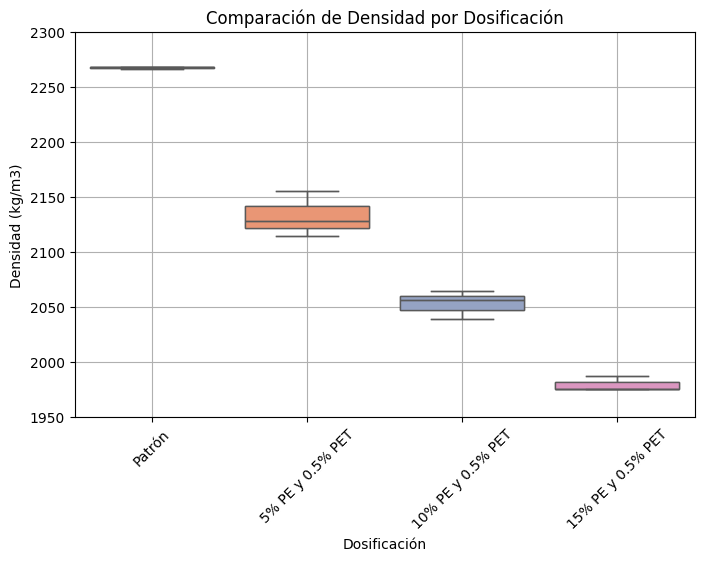

In [19]:
#Graficar Resultados

# Crear el gráfico de comparación de Densidad
plt.figure(figsize=(8, 5))
sns.boxplot(x='Dosificación', y='Densidad', data=df_long_densidad, palette="Set2")
ax = sns.boxplot(x='Dosificación', y='Densidad', data=df_long_densidad, palette="Set2")

# Ajustar los límites del eje y
plt.ylim(1950, 2300)

# Calcular y mostrar las medias como etiquetas
means = df_long_densidad.groupby(['Dosificación'])['Densidad'].mean().values  #Calcular las medianas por grupo

# Personalizar el gráfico
plt.title('Comparación de Densidad por Dosificación')
plt.xlabel('Dosificación')
plt.ylabel('Densidad (kg/m3)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
